In [1]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

In [2]:
# !pip install -q cairocffi editdistance
# !apt install -q libcairo2-dev

# !apt install -q graphviz
# !pip install -q pydot
# !pip install -q matplotlib graphviz pydot

import os
import itertools
import codecs
import re
import datetime
import numpy as np
from scipy import ndimage
# import pylab
import matplotlib.pyplot as plt
from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation
from keras.layers import Reshape, Lambda, Dropout
from keras.layers.merge import add, concatenate
from keras.models import Model
from keras.layers.recurrent import GRU
from keras.optimizers import SGD
from keras.utils.data_utils import get_file
from keras.preprocessing import image
import keras.callbacks

OUTPUT_DIR = 'image_ocr'

# character classes and matching regex filter
regex = r'^[a-z ]+$'
alphabet = u'abcdefghijklmnopqrstuvwxyz '
vocab = '0123456789'

np.random.seed(55)

# Reverse translation of numerical classes back to characters
def labels_to_text(labels):
    ret = []
    for c in labels:
        if c == len(vocab):  # CTC Blank
            ret.append("")
        else:
            ret.append(vocab[c])
    return "".join(ret)

# the actual loss calc occurs here despite it not being
# an internal Keras loss function

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)


# For a real OCR application, this should be beam search with a dictionary
# and language model.  For this example, best path is sufficient.

def decode_batch(test_func, word_batch):
    out = test_func([word_batch])[0]
    ret = []
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, 2:], 1))
        out_best = [k for k, g in itertools.groupby(out_best)]
        outstr = labels_to_text(out_best)
        ret.append(outstr)
    return ret


Using TensorFlow backend.


In [3]:
from keras.optimizers import *

vocab = '0123456789'
img_h = 28
img_w = 150
words_per_epoch = 16000
val_split = 0.2
val_words = int(words_per_epoch * (val_split))

# Network parameters
conv_filters = 64
kernel_size = (3, 3)
pool_size = 2
time_dense_size = 32
rnn_size = 512
minibatch_size = 32

if K.image_data_format() == 'channels_first':
    input_shape = (1, img_w, img_h)
else:
    input_shape = (img_w, img_h, 1)

act = 'relu'
input_data = Input(name='the_input', shape=input_shape, dtype='float32')
inner = Dropout(0.2, name='input_dropout')(input_data)
inner = Conv2D(conv_filters, kernel_size, padding='same',
               activation=act, kernel_initializer='he_normal',
               name='conv1')(inner)
inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max1')(inner)
inner = Conv2D(conv_filters*2, kernel_size, padding='same',
               activation=act, kernel_initializer='he_normal',
               name='conv2')(inner)
inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max2')(inner)
inner = Conv2D(conv_filters*4, kernel_size, padding='same',
               activation=act, kernel_initializer='he_normal',
               name='conv3')(inner)
# inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max3')(inner)
inner = Conv2D(conv_filters*4, kernel_size, padding='same',
               activation=act, kernel_initializer='he_normal',
               name='conv4')(inner)
# inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max4')(inner)

conv_to_rnn_dims = (img_w // (pool_size ** 2), (img_h // (pool_size ** 2)) * conv_filters*4)
inner = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(inner)

# cuts down input size going into RNN:
inner = Dense(time_dense_size, activation=act, name='dense1')(inner)

# Two layers of bidirectional GRUs
# GRU seems to work as well, if not better than LSTM:
gru_1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1')(inner)
gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru1_b')(inner)
gru1_merged = add([gru_1, gru_1b])
gru_2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru2_b')(gru1_merged)

# transforms RNN output to character activations:
inner = Dense(64, kernel_initializer='he_normal',
              name='dense2')(concatenate([gru_2, gru_2b]))
inner = Dense(len(vocab)+1, kernel_initializer='he_normal',
              name='dense3')(inner)
y_pred = Activation('softmax', name='softmax')(inner)
Model(inputs=input_data, outputs=y_pred).summary()

labels = Input(name='the_labels', shape=[10], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
# Keras doesn't currently support loss funcs with extra parameters
# so CTC loss is implemented in a lambda layer
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

# clipnorm seems to speeds up convergence
opt = RMSprop(lr=0.002, decay=1e-6)

model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=opt)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 150, 28, 1)   0                                            
__________________________________________________________________________________________________
input_dropout (Dropout)         (None, 150, 28, 1)   0           the_input[0][0]                  
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 150, 28, 64)  640         input_dropout[0][0]              
__________________________________________________________________________________________________
max1 (MaxPooling2D)             (None, 75, 14, 64)   0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Con

In [4]:
from keras.datasets import mnist
import random
from scipy import misc

def build_synth_data1(data,labels,n,h=img_h,w=img_w):
    
    #Define synthetic image dimensions
    synth_img_height = h
    synth_img_width = w
    dataset_size = n
    #Define synthetic data
    synth_data = np.ndarray(shape=(n,synth_img_height,synth_img_width),
                           dtype=np.float32)
    
    #Define synthetic labels
    synth_labels = [] 
    
    #For a loop till the size of the synthetic dataset
    for i in range(0,dataset_size):
        
        #Pick a random number of digits to be in the dataset
        num_digits = 10
        
        #Randomly sampling indices to extract digits + labels afterwards
        s_indices = [random.randint(0,len(data)-1) for p in range(0,num_digits)]
        
        #stitch images together
        new_image = np.hstack([misc.imresize(cropped(X_train[index]),(28,15)) for index in s_indices])
        #stitch the labels together
        new_label =  [y_train[index] for index in s_indices]
        
        #Resize image
        new_image = misc.imresize(255-new_image,(h,w))
        
        #Assign the image to synth_data
        synth_data[i,:,:] = new_image
        
        #Assign the label to synth_data
        synth_labels.append(tuple(new_label))
        
    #Return the synthetic dataset
    return synth_data[:,:,:,None]/255.0, synth_labels
  
def cropped(image):
    image2 = image.copy()
    a = random.randint(2,9)#
    b = random.randint(2,9)#
    image = image[:,a:(28-b)]
    return image
  
  

In [5]:
from keras.datasets import mnist
import random
from scipy import misc
  

def isolateTheDigit(img):
    # gray1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray1 = img
    im_bw = cv2.threshold(gray1, 5, 1, cv2.THRESH_BINARY)[1]
    h,w=im_bw.shape
    IsdigitStarted=0
    digit_start_left=0
    digit_end_right=w
    
    for l in range(im_bw.shape[1]):
        #print(l,white_count(im_bw,l))
        if white_count_col(im_bw,l)==0 and IsdigitStarted!=0:
            #('digit_end')
            digit_end_right=l
            break
        if white_count_col(im_bw,l)>0 and IsdigitStarted==0:
            #print('digit_start')
            digit_start_left=l
            IsdigitStarted=1
    
    
    IsdigitStarted=0
    digit_start_top,digit_end_bottom=0,28
    #print(image1,im_bw.shape)
    for l in range(im_bw.shape[0]):
        #print(l,white_count(im_bw,l))
        if white_count_row(im_bw,l)==0 and IsdigitStarted!=0:
            #print('digit_end',l)
            digit_end_bottom=l
            break
        if white_count_row(im_bw,l)>0 and IsdigitStarted==0:
            #print('digit_start',l)
            digit_start_top=l
            IsdigitStarted=1
    #print(digit_start_top,digit_end_bottom,digit_start_left,digit_end_right)
    
    IsolatedDigit=gray1[digit_start_top:digit_end_bottom,digit_start_left:digit_end_right]
    return IsolatedDigit


def VerticalOccupation(DigitFrame,occupationPercentage, space_from_top):
    h,w=DigitFrame.shape
    resized_image = cv2.resize(DigitFrame, (w, int(28*occupationPercentage)))
    h,w=resized_image.shape
    LargerFrame=np.zeros((28,w))
    leftoverPixels=28-h
    top_space=int(space_from_top*leftoverPixels)
    LargerFrame[top_space:top_space+h,:]=resized_image
    return LargerFrame


def HorizontalOccupation(DigitFrame,occupationPercentage, space_from_left):
    h,w=DigitFrame.shape
    resized_image = cv2.resize(DigitFrame, (int(28*occupationPercentage),h))
    h,w=resized_image.shape
    LargerFrame=np.zeros((h,28))
    leftoverPixels=28-w
    left_space=int(space_from_left*leftoverPixels)
    LargerFrame[:,left_space:left_space+w]=resized_image
    return LargerFrame


def addEdgeNoise2(img,edge_type):
    h,w=img.shape
    HorEdge=np.full((random.randint(1,2),w),255)
    VertEdge=np.full((h,random.randint(2,5)),255)
    h_e=HorEdge.shape[0]
    v_e=VertEdge.shape[1]
    if edge_type=='up':
        x=random.choice([0,0,0,0,0,1,1,1,1,2,2,3])
        img[x:x+h_e,:]=HorEdge
    elif edge_type=='down':
        x1=random.choice([h-1,h-1,h,h,h,h])
        img[x1-h_e:x1,:]=HorEdge
    elif edge_type=='left':
        y=random.choice([0,0,0,0,0,1,1,1,1,2,2,3])
        img[:,y:y+v_e]=VertEdge
    elif edge_type=='right':
        y1=random.choice([w-10,w-10,w-7,w-15,w-19])
        img[:,y1-v_e:y1]=VertEdge
    else:
        pass
    
    return img
  
def white_count_col(img_bw,colNum):
    h,w=img_bw.shape
    wc=0
    for i in range(h):
        if img_bw[i,colNum]==1:
            wc=wc+1
    return wc
  
def white_count_row(img_bw,rowNum):
    h,w=img_bw.shape
    wc=0
    for i in range(w):
        if img_bw[rowNum,i]==1:
            wc=wc+1
    return wc
  
def build_synth_data2(data,y_labels,n,h=img_h,w=img_w):

    #Define synthetic image dimensions
    synth_img_height = h
    synth_img_width = w
    dataset_size = n
    #Define synthetic data
    synth_data = np.ndarray(shape=(n,synth_img_height,synth_img_width),
                           dtype=np.float32)
    
    #Define synthetic labels
    synth_labels = [] 
    positions = []
    #For a loop till the size of the synthetic dataset
    for d_sz in range(n):
        cutOutDigits=[]
        spacings=[]
        labels=[]
        
        for i in range(9):
            spacing=random.choice([0,0,0,0,0,0,0,0,0,1,2,3,4,8,10,12,15])
            spacings.append(np.zeros((28,int(spacing))))

        for i in range(10):
            index=random.randint(0,len(data)-1)
            im1=data[index]
            labels.append(y_labels[index])
            cutOutDigit=isolateTheDigit(im1)
            occupationPercentageVert=0.1*random.randint(7,10)
            occupationPercentageHor=1
            space_from_top=0.1*random.randint(0,6)
            space_from_left=0
            VerticallyRandomized=VerticalOccupation(cutOutDigit,occupationPercentageVert, space_from_top)
            BothSideRandomized=HorizontalOccupation(VerticallyRandomized,occupationPercentageVert, space_from_left)
            cutOutDigits.append(VerticallyRandomized)
            
        spacing_left=np.zeros((28,random.randint(50,100)))
        spacing_right=np.zeros((28,random.randint(30,100)))
        
        final=np.concatenate((spacing_left,cutOutDigits[0],spacings[0],cutOutDigits[1],spacings[1],cutOutDigits[2],spacings[2],cutOutDigits[3],spacings[3],cutOutDigits[4],spacings[4],cutOutDigits[5],spacings[5],cutOutDigits[6],spacings[6],cutOutDigits[7],spacings[7],cutOutDigits[8],spacings[8],cutOutDigits[9],spacing_right),axis=1)
        sh = final.shape[1]
        spacing_top = np.zeros((random.randint(5,20),sh))
        spacing_bot = np.zeros((random.randint(5,10),sh))
        final=np.concatenate((spacing_top, final, spacing_bot))
        sh1 = final.shape[0]
        positions.append((w*spacing_left.shape[1]//sh, w*spacing_right.shape[1]//sh, h*spacing_top.shape[0]//sh1, h*spacing_bot.shape[0]//sh1))
        edge_list=['up','down','left','right']
        for i in range(len(edge_list)):
            if random.randint(0,1):
                final=addEdgeNoise2(final,edge_list[i])
        final=255-final

        font                   = cv2.FONT_HERSHEY_SIMPLEX
        position = (random.randint(10,15),random.randint(10,15))
        fontScale              = 0.5
        fontColor              = (0,0)
        lineType               = 2

        cv2.putText(final,"NPI#:", 
            position, 
            font, 
            fontScale,
            fontColor,
            lineType)

        noise_factor = random.choice([0.01,0.02,0.03])
        mask = final==0
        c = np.count_nonzero(mask)
        threshold_prob = noise_factor * 100.
        nums = np.random.randint(1,100, c)
        vals = np.where(nums <= threshold_prob, np.random.randint(1,100, c) , 0)
        final[mask] = vals

        final = cv2.resize(final,(w,h))

            #Assign the image to synth_data
        synth_data[d_sz,:,:] = final
        
        #Assign the label to synth_data
        synth_labels.append(labels)
    abs_bb_positions = np.array(positions)
    pad = 2
    abs_bb_positions -= pad
    
    rel_bb_positions = np.zeros_like(abs_bb_positions, dtype=float)
    rel_bb_positions[:,:2] = abs_bb_positions[:,:2]/w
    rel_bb_positions[:,2:] = abs_bb_positions[:,2:]/h
    
    xywh = np.zeros_like(abs_bb_positions, dtype=float)
    xywh[:,0] = rel_bb_positions[:,0]
    xywh[:,1] = rel_bb_positions[:,2]
    xywh[:,2] = 1-rel_bb_positions[:,1]-rel_bb_positions[:,0]
    xywh[:,3] = 1-rel_bb_positions[:,3]-rel_bb_positions[:,2]

    #Return the synthetic dataset
    return synth_data[:,:,:,None]/255.0, synth_labels#, abs_bb_positions, rel_bb_positions, xywh


In [6]:
def data(x, y):
    #y_ = np.ones((bs, 16))
    #y_[:,:10] = y
    y = np.array([[int(a) for a in b] for b in y])
    inputs = {
        'the_input': x.transpose(0,2,1,3),
        'the_labels': y,
        'input_length': np.array([np.array([35]*len(x))]).T,
        'label_length': np.array([np.array([10]*len(x))]).T,
      }
    outputs = {'ctc': np.zeros([len(x)])}
    return inputs, outputs

CPU times: user 4min 7s, sys: 0 ns, total: 4min 7s
Wall time: 4min 9s


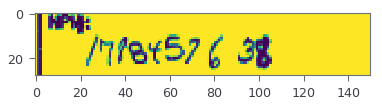

In [10]:
%%time
%matplotlib inline
import cv2

bs = 32
N = bs*120

from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
x, y, *_ = build_synth_data2(X_train, y_train, N)
plt.imshow(x[10,...,0])

/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


CPU times: user 1.05 s, sys: 51.7 ms, total: 1.1 s
Wall time: 1.1 s


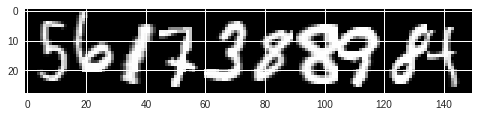

In [6]:
%%time
import cv2

bs = 32
N = bs*20

from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
x_1, y_1, *_ = build_synth_data1(X_train, y_train, N)
plt.imshow(x_1[10,...,0])

In [11]:
opt = Adam(lr=0.0002, decay=1e-6)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=opt)

model.fit(*data(x, y), epochs=50, validation_split=0.1, verbose=2)

Train on 3456 samples, validate on 384 samples
Epoch 1/50
 - 31s - loss: 18.3311 - val_loss: 13.7899
Epoch 2/50
 - 24s - loss: 10.8836 - val_loss: 11.2874
Epoch 3/50
 - 25s - loss: 9.2590 - val_loss: 10.2882
Epoch 4/50
 - 25s - loss: 8.1768 - val_loss: 8.5081
Epoch 5/50
 - 25s - loss: 7.5070 - val_loss: 8.2783
Epoch 6/50
 - 25s - loss: 6.9400 - val_loss: 7.7319
Epoch 7/50
 - 23s - loss: 6.5000 - val_loss: 7.4212
Epoch 8/50
 - 25s - loss: 6.0530 - val_loss: 6.9566
Epoch 9/50
 - 33s - loss: 5.6311 - val_loss: 7.4428
Epoch 10/50
 - 30s - loss: 5.4926 - val_loss: 7.0517
Epoch 11/50
 - 28s - loss: 5.1609 - val_loss: 6.6075
Epoch 12/50
 - 26s - loss: 4.9038 - val_loss: 6.5336
Epoch 13/50
 - 27s - loss: 4.6870 - val_loss: 6.0797
Epoch 14/50
 - 28s - loss: 4.3207 - val_loss: 5.9098
Epoch 15/50
 - 28s - loss: 4.1779 - val_loss: 5.8719
Epoch 16/50
 - 29s - loss: 4.0179 - val_loss: 6.0010
Epoch 17/50
 - 29s - loss: 3.8000 - val_loss: 5.6801
Epoch 18/50
 - 25s - loss: 3.6663 - val_loss: 5.5507
Epo

KeyboardInterrupt: 

In [12]:
test_func = K.function([input_data], [y_pred])
def decode_batch(test_func, word_batch):
    out = test_func([word_batch])[0]
    # print(out.shape)
    ret = []
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, 2:], 1))
        # print(out_best)
        out_best = [k for k, g in itertools.groupby(out_best)]
        outstr = labels_to_text(out_best)
        ret.append(outstr)
    return ret

In [13]:
%%time
w, ws, c, cs = 0,0,0,0 # correct-words, all-words, correct-characters, all-characters
# (X_train, y_train), (X_test, y_test) = mnist.load_data()
a, b, *_ = build_synth_data2(X_train, y_train, 200)

for idx, dat in enumerate(zip(a, b)):
    print('Batch', idx, end='\r')
    img, truth = dat[0], dat[1]
    truth = ''.join(str(i) for i in truth)
    pred = [i[:10] for i in decode_batch(test_func, [img.transpose(1,0,2)])][0]
    w += pred==truth
    ws += 1
    
    c += sum(sum(pred_c==truth_c for pred_c, truth_c in zip(p, t)) for p, t in zip(pred, truth))
    cs += sum(len(t) for t in truth)
    
#     print(pred, truth)
#     break
    
print(f'Character accuracy: {100*(c)/cs:.3f} %\nWord accuracy: {100*(w)/ws:.3f} %')

Character accuracy: 70.300 %
Word accuracy: 18.000 %
CPU times: user 42.2 s, sys: 3.67 s, total: 45.9 s
Wall time: 29.1 s


In [14]:
model.save_weights('1.wts')

In [277]:
# Character accuracy: 69.100 %
# Word accuracy: 22.000 %
# CPU times: user 12.9 s, sys: 1.39 s, total: 14.3 s
# Wall time: 13.9 s

(13, 200)

Text(0.5,1,"['5052349773']")

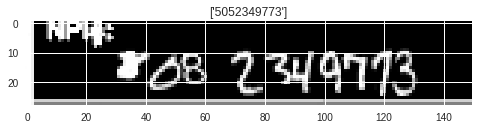

In [38]:
N =2
plt.imshow(a[N,:,:,0])
plt.title(str([i[:10] for i in decode_batch(test_func, [a[N].transpose(1,0,2)])]))

In [60]:
lzip = lambda a, b: list(zip(a, b))

outs = lzip(test_func([[a[N].transpose(1,0,2)]])[0][0].argmax(-1),
            test_func([[a[N].transpose(1,0,2)]])[0][0].max(-1))[2:]

[(idx+2, i) for idx, i in enumerate(outs)]

[(2, (10, 0.9999995)),
 (3, (10, 0.99999976)),
 (4, (10, 0.9999813)),
 (5, (10, 0.9999747)),
 (6, (10, 0.9999931)),
 (7, (10, 0.9999895)),
 (8, (10, 0.99999976)),
 (9, (5, 0.9885324)),
 (10, (10, 0.99995327)),
 (11, (10, 0.99994934)),
 (12, (0, 0.98095185)),
 (13, (10, 0.9999664)),
 (14, (5, 0.3404038)),
 (15, (10, 0.99985564)),
 (16, (10, 0.99989235)),
 (17, (10, 0.99999976)),
 (18, (2, 0.9989365)),
 (19, (10, 0.99971694)),
 (20, (10, 0.9999999)),
 (21, (3, 0.98895544)),
 (22, (10, 0.9999651)),
 (23, (4, 0.9999943)),
 (24, (10, 0.9998957)),
 (25, (10, 0.9988709)),
 (26, (9, 0.79380566)),
 (27, (10, 0.99997973)),
 (28, (7, 0.99280035)),
 (29, (10, 0.9999784)),
 (30, (7, 0.9992281)),
 (31, (10, 0.99951684)),
 (32, (3, 0.99999416)),
 (33, (10, 0.9993973)),
 (34, (10, 0.9999937)),
 (35, (10, 0.9999995)),
 (36, (10, 0.9999982))]

In [55]:
150*8/37

32.432432432432435

In [58]:
150*9/37

36.486486486486484